This notebook: take what was developed in `N400.ipynb` and sanity-check on the actual Broderick et al 2018 N400 dataset.

In [1]:
import itertools
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

# Transformers prep
import os
os.environ["TRANSFORMERS_CACHE"] = str((Path(".") / "transformers_cache").resolve())
import transformers
import torch
RECOMPUTE_SURPRISALS = False

DATA_DIR = Path("/om/data/public/broderick2018/N400")
EEG_DIR = DATA_DIR / "EEG"
STIM_FILE = DATA_DIR / "Stimuli" / "Sentences.txt"

In [2]:
# Metadata for Broderick et al 2018
NUM_DATA_CHANNELS = 128
# 2 mastoid channels
NUM_REFERENCE_CHANNELS = 2
NUM_CHANNELS = NUM_DATA_CHANNELS + NUM_REFERENCE_CHANNELS
SAMPLE_RATE = 128

data_channels = [f"V{i + 1}" for i in range(NUM_DATA_CHANNELS)]
reference_channels = [f"M{i + 1}" for i in range(NUM_REFERENCE_CHANNELS)]
channel_names = data_channels + reference_channels

# EEG Processing parameters
EPOCH_WINDOW = (-0.2, 0.7)
TEST_WINDOW = (0.4, 0.45)

# EEG band-pass filter parameters
FILTER_LOW = 1.
FILTER_HIGH = 8.

In [3]:
%load_ext autoreload
%autoreload 2
import utils

In [38]:
BRODERICK_EPOCH_TMIN = -0.1
BRODERICK_EPOCH_TMAX = 0.7

In [119]:
EEG_DIR = Path("broderick2018/N400/EEG")

for idx in range(1, 10):
    data = scipy.io.loadmat(EEG_DIR / f"Subject{idx}.mat")
    
    try:
        np.testing.assert_equal(data["eegData_hiCloze"], data["eegData_loCloze"])
    except:
        print(f"Subject {idx} has differing high- and low-cloze data.")
    else:
        print(f"Subject {idx} has the SAME high- and low-cloze data.")

Subject 1 has the SAME high- and low-cloze data.
Subject 2 has the SAME high- and low-cloze data.
Subject 3 has the SAME high- and low-cloze data.
Subject 4 has the SAME high- and low-cloze data.
Subject 5 has the SAME high- and low-cloze data.
Subject 6 has the SAME high- and low-cloze data.
Subject 7 has the SAME high- and low-cloze data.
Subject 8 has the SAME high- and low-cloze data.
Subject 9 has the SAME high- and low-cloze data.


In [120]:
data["mastoids_loCloze"][0]

array([[-11467.071 , -11472.873 , -11471.39  , ...,  -7803.503 ,
         -7849.871 ,  -7815.7764],
       [-11467.326 , -11470.376 , -11467.142 , ...,  -7778.0054,
         -7844.358 ,  -7804.766 ],
       [-11466.014 , -11471.668 , -11473.688 , ...,  -7764.9365,
         -7837.6587,  -7810.699 ],
       ...,
       [-11473.331 , -11469.67  , -11495.502 , ...,  -7784.001 ,
         -7816.2393,  -7795.961 ],
       [-11476.721 , -11478.991 , -11489.718 , ...,  -7787.0186,
         -7829.3467,  -7791.2476],
       [-11469.306 , -11494.422 , -11481.857 , ...,  -7784.8594,
         -7833.6416,  -7799.294 ]], dtype=float32)

In [121]:
data["mastoids_hiCloze"][0]

array([[-11462.849 , -11461.286 , -11403.646 , ...,  -7816.7915,
         -7722.663 ,  -7707.605 ],
       [-11459.308 , -11458.841 , -11400.221 , ...,  -7816.5376,
         -7720.1357,  -7709.8813],
       [-11456.54  , -11460.083 , -11398.433 , ...,  -7817.317 ,
         -7727.7964,  -7717.5654],
       ...,
       [-11425.988 , -11424.4375, -11407.307 , ...,  -7808.671 ,
         -7732.048 ,  -7737.2593],
       [-11432.259 , -11435.507 , -11410.458 , ...,  -7806.7773,
         -7734.8833,  -7736.436 ],
       [-11435.922 , -11431.974 , -11413.168 , ...,  -7800.156 ,
         -7730.139 ,  -7735.0186]], dtype=float32)

In [ ]:
test = scipy.io.loadmat(EEG_DIR / "Subject1.mat")

In [126]:
def load_epochs(times, data, mastoid_data, event_name, event_id):
    """
    Process data from Broderick et al N400 experiment.
    
    Below, n_samples = num samples per epoch.
    
    Args:
        times: ndarray 1 * n_samples
        data: ndarray n_channels * n_samples * n_epochs
        mastoid_data: ndarray n_mastoid_channels * n_samples * n_epochs
        event_id: desired event ID describing epoch event
    """
    # NB does not check that `channel_names` etc. is consistent with channel count in data
    
    n_samples = times.shape[1]
    mne_info = mne.create_info(ch_names=channel_names, ch_types=["eeg"] * len(channel_names),
                               sfreq=SAMPLE_RATE)
    
    # Simulate events representation -- add an event at t=0 for each epoch.
    # Find the sample closest to t=0 in each epoch.
    onset_idx = np.abs(times - 0).flatten().argmin()
    event_sample_idxs = np.arange(data.shape[2]) * n_samples + onset_idx
    event_arr = np.column_stack([
        event_sample_idxs,
        np.zeros_like(event_sample_idxs),
        event_id * np.ones_like(event_sample_idxs)
    ])
    
    # Concatenate + reshape data; create MNE epochs representation.
    epoch_data_raw = np.transpose(np.concatenate([data, mastoid_data], axis=0), (2, 0, 1)) / 1e6
    epoch_data = mne.EpochsArray(epoch_data_raw, mne_info, tmin=BRODERICK_EPOCH_TMIN,
                                 events=event_arr, event_id={event_name: event_id}) \
        .set_eeg_reference(reference_channels) \
        .apply_baseline()
    
    epoch_data.average().plot()
    
    return epoch_data

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


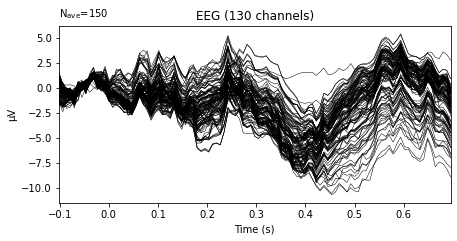

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)


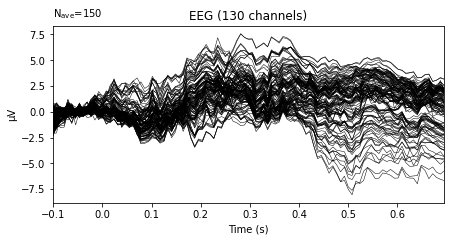

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped


In [127]:
event_ids = {"loCloze": 1, "hiCloze": 2}

all_epochs = mne.concatenate_epochs([
    load_epochs(test["TimeAxis"], test["eegData_loCloze"], test["mastoids_loCloze"], event_name="loCloze", event_id=1),
    load_epochs(test["TimeAxis"], test["eegData_hiCloze"], test["mastoids_hiCloze"], event_name="hiCloze", event_id=2),
])

In [134]:
df = all_epochs.crop(*TEST_WINDOW).to_data_frame()
df

,time,condition,epoch,V1,V2,V3,V4,V5,V6,V7,...,V121,V122,V123,V124,V125,V126,V127,V128,M1,M2
0,398,loCloze,0,-15.291094,-7.631410,-10.075513,-14.842022,-15.264909,-10.658554,-11.412610,...,-16.393589,-16.365649,-14.302005,-13.399264,-23.795167,-24.077882,-23.257332,-23.025953,1.608394,-1.608394
1,406,loCloze,0,-12.881181,-5.026384,-8.686446,-13.578217,-12.934274,-10.178458,-10.471741,...,-17.408731,-17.802913,-14.889669,-14.547294,-23.144289,-23.080668,-23.085794,-22.737243,2.847053,-2.847053
2,414,loCloze,0,-13.230543,-3.042696,-5.688868,-9.239186,-9.417600,-8.084845,-8.077544,...,-20.355202,-20.559861,-14.411202,-13.274758,-20.437516,-20.802886,-21.538926,-20.713712,4.378147,-4.378147
3,422,loCloze,0,-9.742507,-2.534369,-5.455804,-11.055730,-12.074198,-8.636420,-9.224700,...,-15.376818,-15.512558,-13.020272,-11.039846,-22.771644,-23.050749,-23.671655,-23.261577,-0.261702,0.261702
4,430,loCloze,0,-16.378995,-8.810828,-12.650620,-19.111671,-21.325025,-17.212737,-17.618943,...,-18.298376,-18.109784,-19.909265,-19.523787,-26.310902,-25.889071,-25.779179,-26.532615,-0.569969,0.569969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,422,hiCloze,299,-9.895984,-8.854429,-6.513304,-0.556864,7.508755,4.148460,4.239779,...,3.010700,3.523842,-1.511112,-1.067560,6.100171,5.344740,6.135981,5.171485,3.142815,-3.142815
2396,430,hiCloze,299,-10.194124,-8.921382,-5.972788,-1.123109,5.849604,2.801302,3.510321,...,3.118733,3.510105,-1.768390,-0.006172,6.472700,5.917852,6.532143,5.376841,2.840135,-2.840135
2397,438,hiCloze,299,-8.946384,-8.771672,-6.135769,-2.969456,3.260527,-0.193832,1.410422,...,1.955511,1.805319,-2.945233,-1.968731,5.247895,5.114994,5.148605,4.315133,2.393100,-2.393100
2398,445,hiCloze,299,-4.365674,-5.685560,-2.028753,-0.561055,5.323407,1.742854,2.632084,...,3.910590,2.490772,-0.967453,0.575235,4.282695,3.496239,4.224558,4.024561,2.520691,-2.520691


## Statistical test

In [161]:
def main_effect_test(electrode_data):
    electrode_data = electrode_data.groupby(["condition", "epoch"]).value.mean()
    return pd.Series(scipy.stats.ttest_ind(electrode_data.loc["hiCloze"], electrode_data.loc["loCloze"]),
                     index=["tval", "pval"])
    
ttest_results = df.melt(id_vars=["time", "condition", "epoch"], var_name="electrode") \
    .set_index(["electrode", "condition"]) \
    .groupby("electrode") \
    .apply(main_effect_test)

In [164]:
ttest_results.sort_values("pval")

,tval,pval
electrode,,
V5,1.632500,0.103630
V4,1.628054,0.104570
V21,1.627961,0.104590
V18,1.618682,0.106574
V22,1.616376,0.107071
...,...,...
V92,1.299428,0.194801
V93,1.270844,0.204775
V94,1.225516,0.221348
